In [8]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from torch import nn
from pathlib import Path
from torch.optim import Adam
from utils.utils import rmse_error
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from datasets.celegans import CElegansDataset
from utils.plotting import plot_celegans_neural_data, plot_celegans_neural_predictions

device = 'cuda'

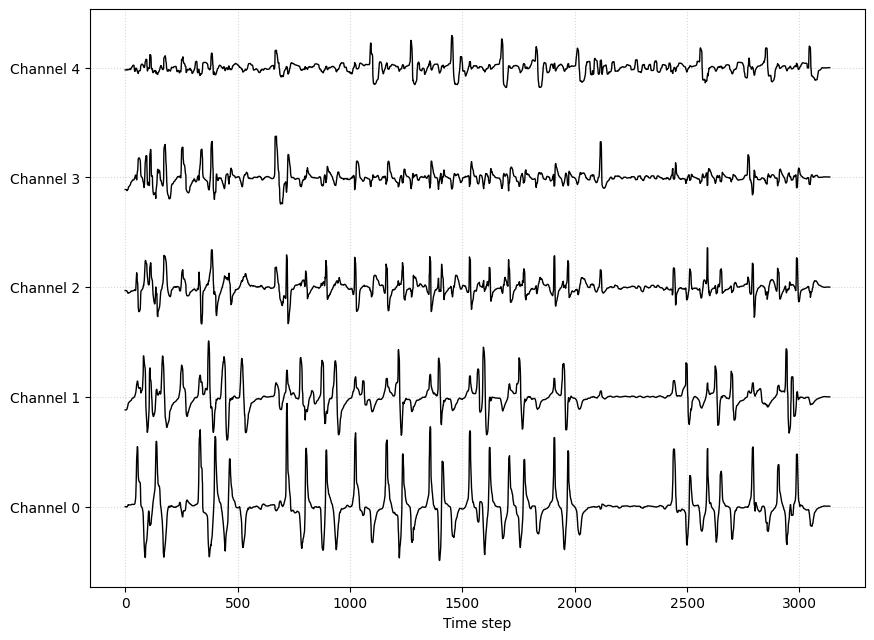

In [9]:
dataset = CElegansDataset(paths=Path.cwd() / 'datasets' / 'CElegans' / 'worm_1',
                          use_pca=True, mode='full',
                          device=device)

x_neural = dataset.series
channels = x_neural.shape[1]

plot_celegans_neural_data(x_neural)



### 1 - Traditional reservoir computing

Fit RMSE = 0.007
Forecast RMSE = 0.081


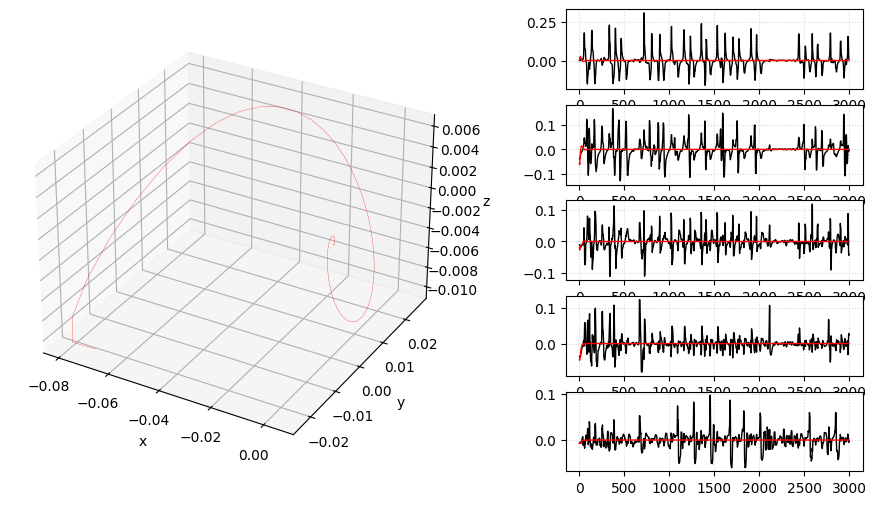

In [3]:
from models.reservoir import ReservoirModel

model = ReservoirModel(features_dim=channels,
                       N_nodes=200, connectivity_density=0.2,
                       spectral_radius=0.1, alpha_regularizer=1e-5,
                       input_weight_strength=0.1,
                       predict_mode='next').to(device)

loss = model.fit(x_neural)
print(f'Fit RMSE = {loss:.3f}')

x_pred = model.generate(x_init=x_neural[0,:], num_steps=3000)

plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### 2 - Polynomial Embeddings

Fit RMSE = 0.007
Forecast RMSE = 0.084


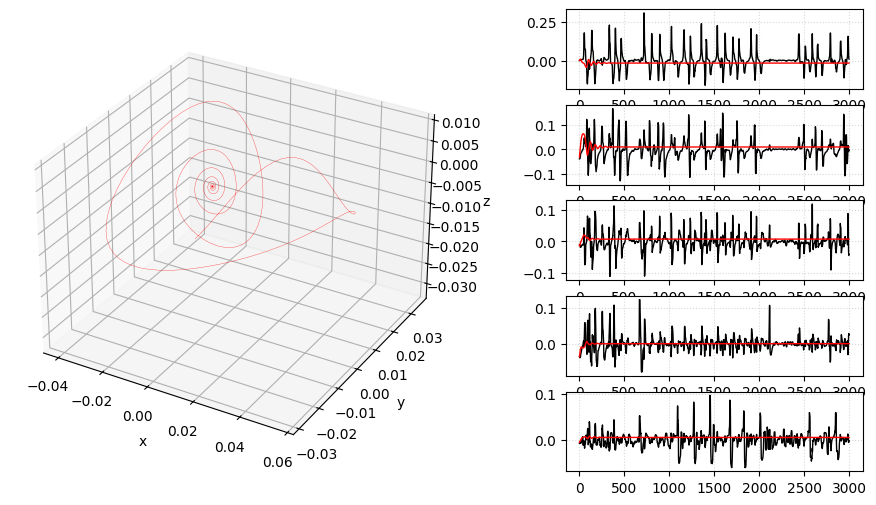

In [9]:
from models.polynomial_embedding import PolynomialEmbeddingModel

model = PolynomialEmbeddingModel(features_dim=channels,
                                 k_steps=3, skip=1,
                                 alpha_regularizer=1e-3,
                                 predict_mode='residual').to(device)

loss = model.fit(x_neural)
print(f'Fit RMSE = {loss:.3f}')

x_pred = model.generate(x_init=x_neural[0:10,:], num_steps=3000)

plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 



### 3 - Recurrent model

100%|██████████| 20000/20000 [06:23<00:00, 52.09it/s, loss=0.000649]


Forecast RMSE = 0.566


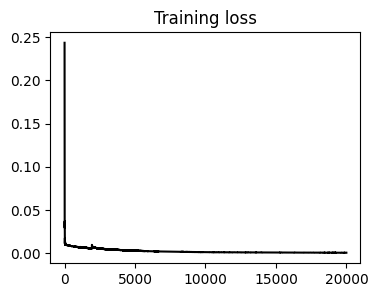

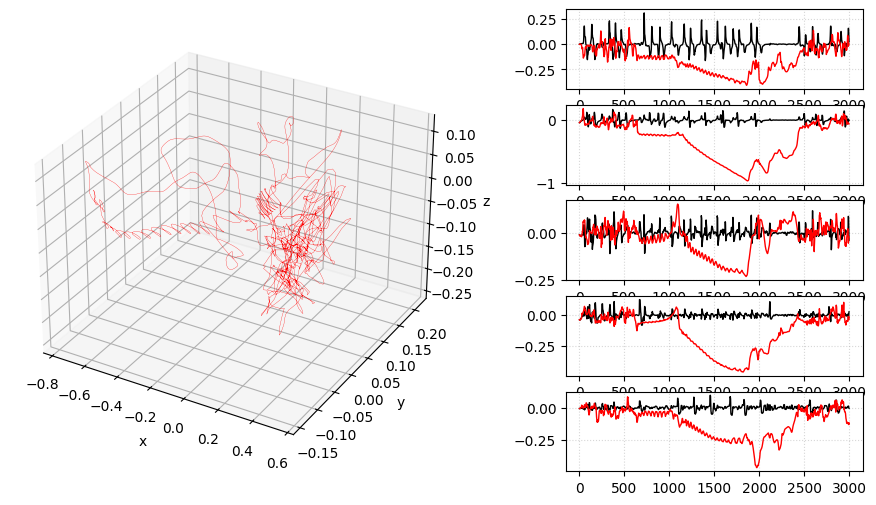

In [14]:
from models.recurrent import RecurrentModel

encoder_model = nn.Sequential(nn.Linear(5, 32), 
                              nn.SELU(),
                              nn.Linear(32, 64))

decoder_model = nn.Sequential(nn.Linear(64, 32), 
                              nn.SELU(),
                              nn.Linear(32, 5))

recurrent_model = nn.LSTM(input_size=64, hidden_size=64, num_layers=4)

model = RecurrentModel(features_dim=channels,
                       encoder_model=encoder_model,
                       decoder_model=decoder_model,
                       recurrent_model=recurrent_model,
                       predict_mode='residual').to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


loss_history = model.fit(x_neural, optimizer=optimizer, epochs=20000)
plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_neural[0,:], num_steps=3000)
plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### 4 - Neural Autoregressive model

In [15]:
dataset = CElegansDataset(paths=Path.cwd() / 'datasets' / 'CElegans' / 'worm_1',
                          use_pca=True, mode='window', window_length=40, window_shift=5,
                          device=device)

x_neural = dataset.series
channels = x_neural.shape[1]

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 500/500 [03:48<00:00,  2.19it/s, Loss=8.3717e-03]


Forecast RMSE = 0.188


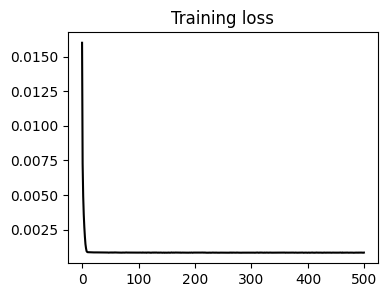

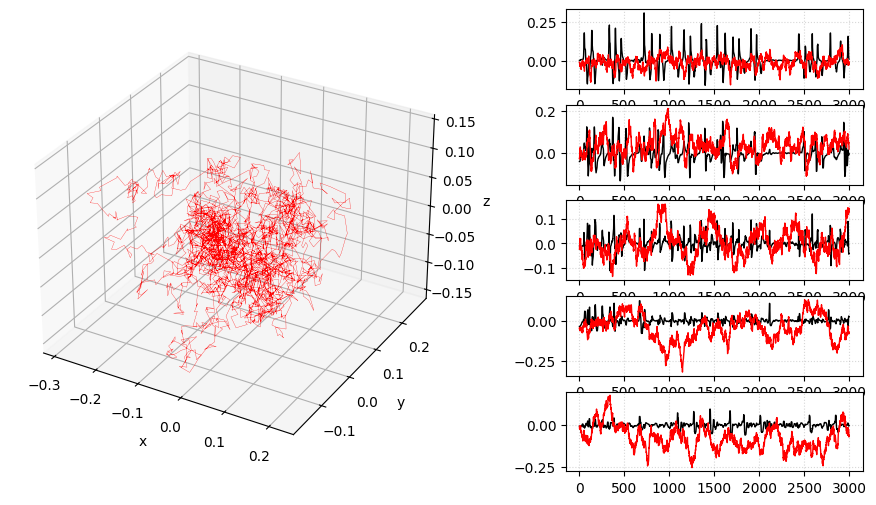

In [11]:
from models.autoregressive_neural import NeuralAutoregressiveResidual

model = NeuralAutoregressiveResidual(features_dim=channels, sigma=1e-2).to(device)
optimizer = Adam(model.parameters(), lr=3e-4)

loss_history = model.fit(dataloader, optimizer, epochs=500)

plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_neural[0,:], num_steps=3000)
plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 

# Original neural data, no PCA

/home/nuzzi/Projects/CElegansNetwork/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


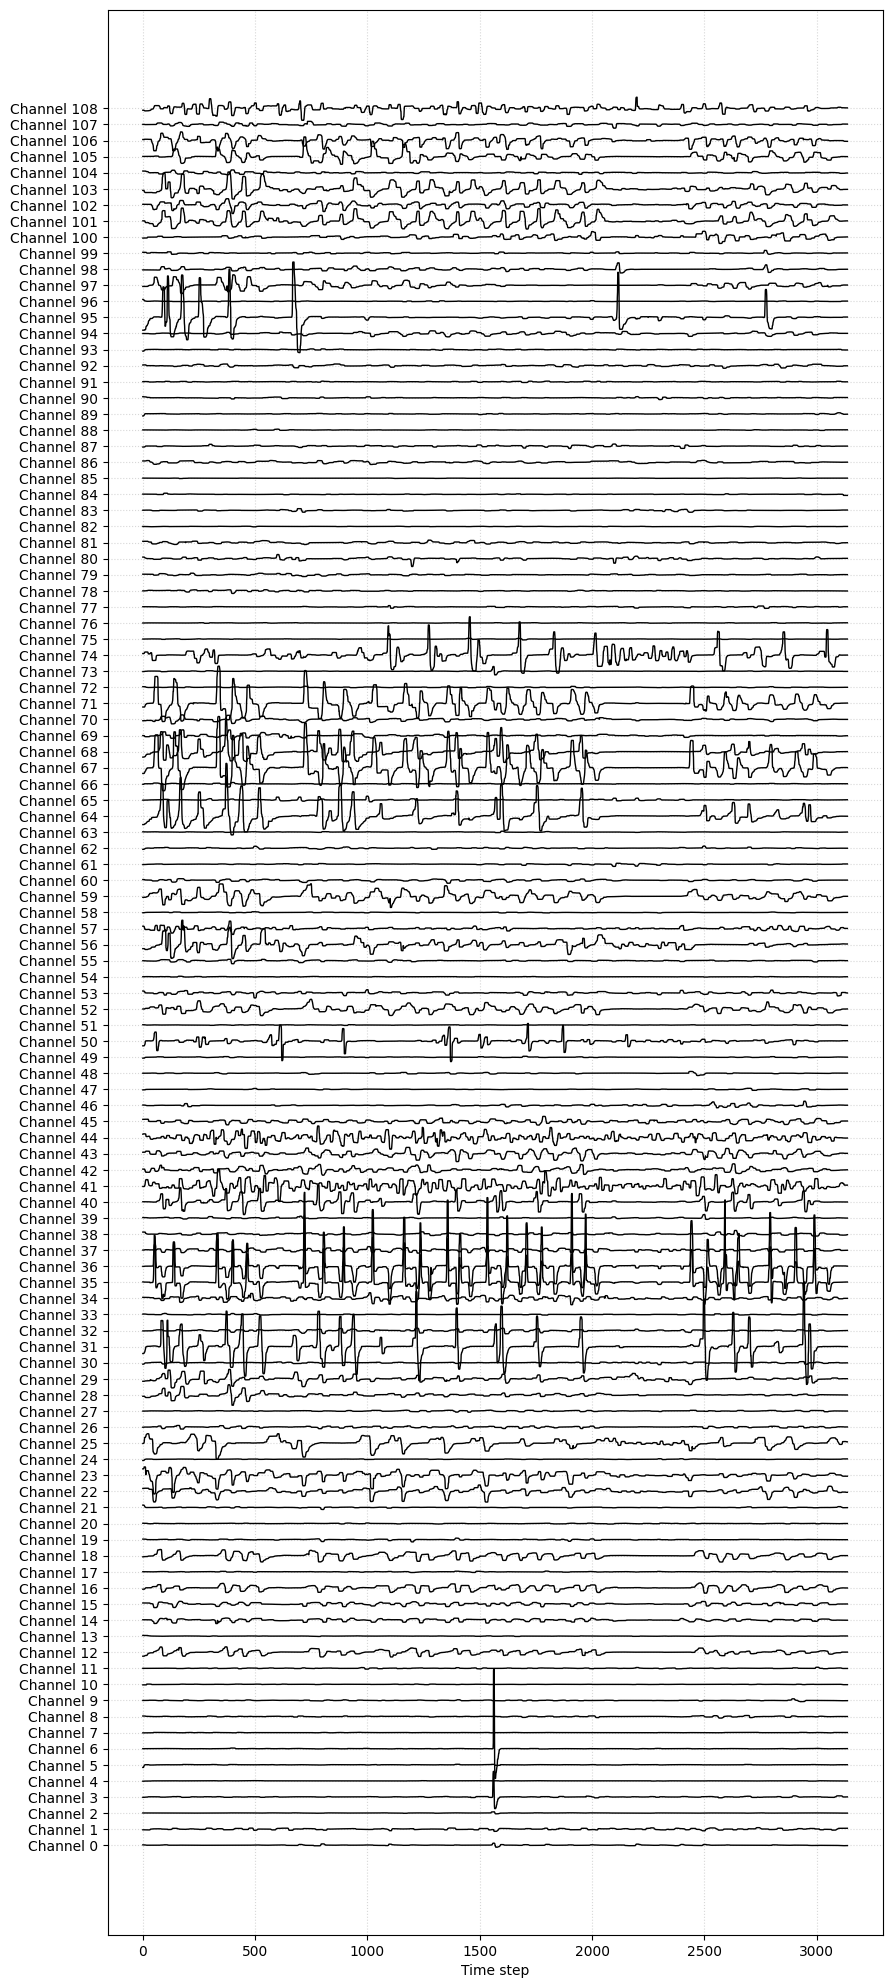

In [2]:
dataset = CElegansDataset(paths=Path.cwd() / 'datasets' / 'CElegans' / 'worm_1',
                          use_pca=False, mode='full', standardize=False,
                          device=device)

x_neural = dataset.series
channels = x_neural.shape[1]

plot_celegans_neural_data(x_neural)



### Traditional reservoir computing

Fit RMSE = 0.013
Forecast RMSE = 0.090


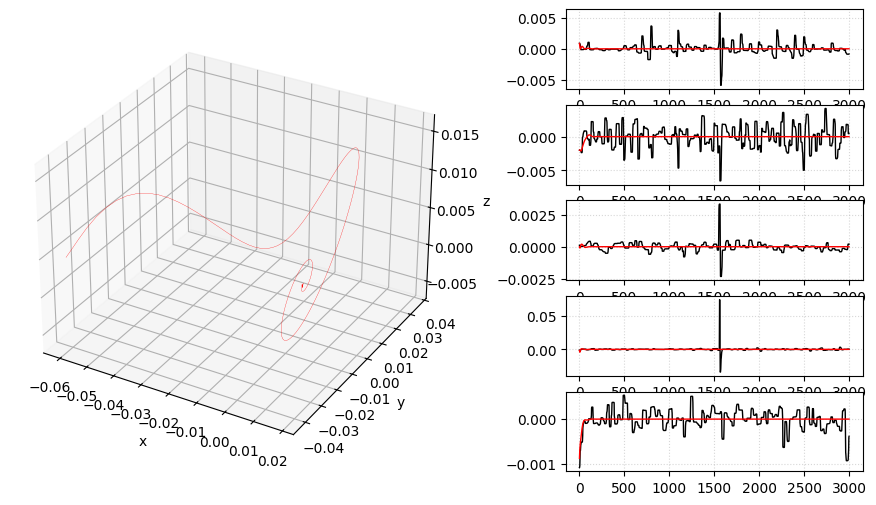

In [21]:
from models.reservoir import ReservoirModel

model = ReservoirModel(features_dim=channels,
                       N_nodes=200, connectivity_density=0.2,
                       spectral_radius=0.1, alpha_regularizer=1e-5,
                       input_weight_strength=0.1,
                       predict_mode='next').to(device)

loss = model.fit(x_neural)
print(f'Fit RMSE = {loss:.3f}')

x_pred = model.generate(x_init=x_neural[0,:], num_steps=3000)

plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### Recurrent model

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [06:23<00:00, 52.14it/s, loss=0.00448]


Forecast RMSE = 46.095


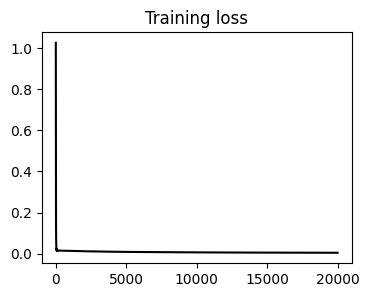

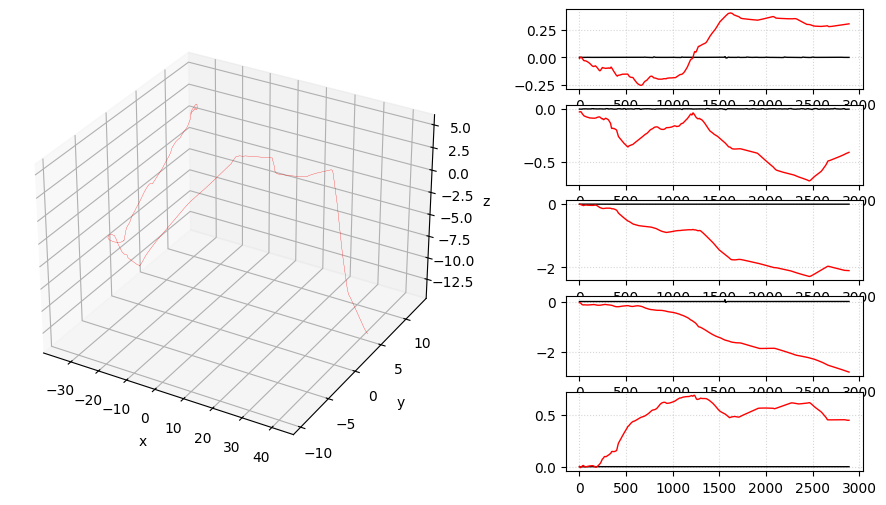

In [4]:
from models.recurrent import RecurrentModel

encoder_model = nn.Sequential(nn.Linear(channels, 64), 
                              nn.SELU(),
                              nn.Linear(64, 64))

decoder_model = nn.Sequential(nn.Linear(64, 64), 
                              nn.SELU(),
                              nn.Linear(64, channels))

recurrent_model = nn.LSTM(input_size=64, hidden_size=64, num_layers=4)

model = RecurrentModel(features_dim=channels,
                       encoder_model=encoder_model,
                       decoder_model=decoder_model,
                       recurrent_model=recurrent_model,
                       predict_mode='residual').to(device)

optimizer = Adam(model.parameters(), lr=1e-3)


loss_history = model.fit(x_neural, optimizer=optimizer, epochs=20000)
plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_neural[0,:], num_steps=3000)
plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 


### Neural Autoregressive model

In [5]:
dataset = CElegansDataset(paths=Path.cwd() / 'datasets' / 'CElegans' / 'worm_1',
                          use_pca=True, mode='window', window_length=40, window_shift=5,
                          device=device)

x_neural = dataset.series
channels = x_neural.shape[1]

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


100%|██████████| 500/500 [03:42<00:00,  2.25it/s, Loss=3.2646e-03]


Forecast RMSE = 0.082


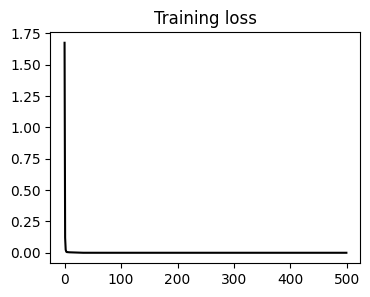

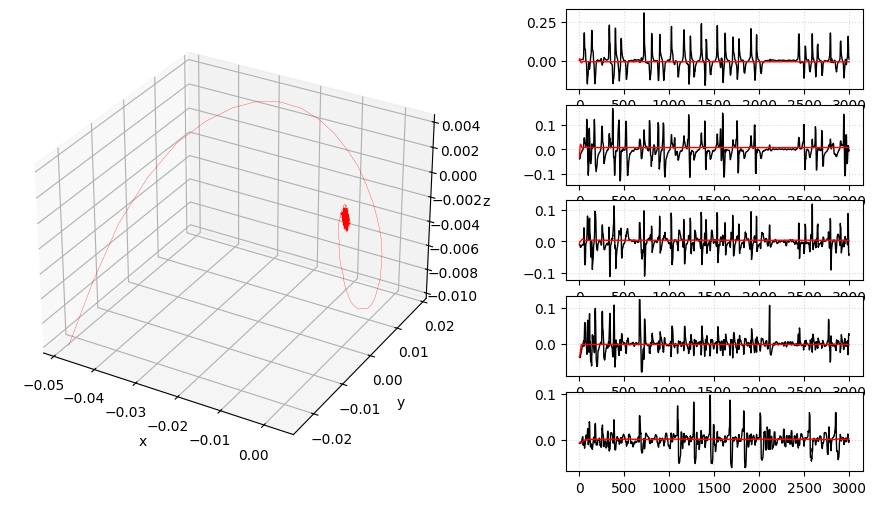

In [6]:
from models.autoregressive_neural import NeuralAutoregressiveResidual

model = NeuralAutoregressiveResidual(features_dim=channels, sigma=1e-4).to(device)
optimizer = Adam(model.parameters(), lr=3e-4)

loss_history = model.fit(dataloader, optimizer, epochs=500)

plt.figure(figsize=(4,3))
plt.plot(loss_history, 'k')
plt.title('Training loss')

x_pred = model.generate(x_init=x_neural[0,:], num_steps=3000)
plot_celegans_neural_predictions(x_pred, x_true=x_neural[1:,:])

prediction_error = rmse_error(x_neural[1:,:], x_pred)
print(f'Forecast RMSE = {prediction_error:.3f}') 